In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import datetime
import yfinance as yf


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.signal import temporal_signal_split

C:\Users\akhan147\Anaconda3\envs\trader\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from pathlib import Path
data_dir = Path(r'F:\cc_data')
model_dir = data_dir.absolute() / 'models'

In [4]:
# GPU support
DEVICE = torch.device('cpu') # cuda
shuffle=True
batch_size = 32

# Data

In [5]:
start = datetime.datetime(2020, 1, 1)
end_train = datetime.datetime(2024, 4, 1)
end_test = datetime.datetime.now()


|Rank	| Symbol |	Fund | Name |
|---|---|----|----|
|1	| SPY	| SPDR S&P 500 ETF Trust |
|2	| IVV	| iShares Core S&P 500 ETF |
|3	| VOO	| Vanguard S&P 500 ETF|
|4	| VTI	| Vanguard Total Stock Market ETF|
|5	| QQQ	| Invesco QQQ Trust Series I|
|6	| VEA	| Vanguard FTSE Developed Markets ETF|
|7	| VUG	| Vanguard Growth ETF|
|8	| VTV	| Vanguard Value ETF|
|9	| IEFA	| iShares Core MSCI EAFE ETF|
|10	| AGG	| iShares Core U.S. Aggregate Bond ETF

[Top ETFs](https://www.marketwatch.com/tools/top-25-etfs)

In [6]:
import yfinance as yf

tickers = ["SPY", "IVV", "VOO", "VTI", "QQQ", "VEA", "VUG", "VTV", "IEFA", "AGG"]

df_train = yf.download(tickers, start=start, end=end_train)
df_test = yf.download(tickers, start=end_train, end=end_test)
df_train.head()

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


Price                       Adj Close                                     \
Ticker                            AGG       IEFA         IVV         QQQ   
Date                                                                       
2020-01-02 00:00:00+00:00   99.801216  57.861580  302.929321  209.976089   
2020-01-03 00:00:00+00:00  100.093483  57.141933  300.599121  208.052750   
2020-01-06 00:00:00+00:00  100.013794  57.343777  301.787415  209.393250   
2020-01-07 00:00:00+00:00   99.907501  57.212135  300.961212  209.364090   
2020-01-08 00:00:00+00:00   99.792366  57.343777  302.492950  210.937775   

Price                                                                     \
Ticker                            SPY        VEA         VOO         VTI   
Date                                                                       
2020-01-02 00:00:00+00:00  302.208618  38.784161  276.999207  153.396133   
2020-01-03 00:00:00+00:00  299.920227  38.312675  274.975647  152.419891   
2020-01-06 00:00:00+00:00  301.064453  38.443645  276.006042  152.940552   
2020-01-07 00:00:00+00:00  300.217926  38.382526  275.244904  152.577957   
2020-01-08 00:00:00+00:00  301.817963  38.434914  276.665100  153.331070   

Price                                              ...   Volume            \
Ticker                            VTV         VUG  ...      AGG      IEFA   
Date                                               ...                      
2020-01-02 00:00:00+00:00  106.480377  179.231476  ...  6791400  10523100   
2020-01-03 00:00:00+00:00  105.631676  177.999710  ...  3664300   9663700   
2020-01-06 00:00:00+00:00  105.764282  179.144196  ...  8131600   7468300   
2020-01-07 00:00:00+00:00  105.357590  179.086014  ...  2883000   5815100   
2020-01-08 00:00:00+00:00  105.605125  180.492401  ...  7323100   8249700   

Price                                                                     \
Ticker                         IVV       QQQ       SPY      VEA      VOO   
Date                                                                       
2020-01-02 00:00:00+00:00  4070500  30969400  59151200  8229000  3142400   
2020-01-03 00:00:00+00:00  4290400  27518900  77709700  9697300  3247900   
2020-01-06 00:00:00+00:00  4212000  21655300  55653900  8579400  2777100   
2020-01-07 00:00:00+00:00  3632500  22139300  40496400  7884600  2251800   
2020-01-08 00:00:00+00:00  3912100  26397300  68296000  9948100  3719500   

Price                                                 
Ticker                         VTI      VTV      VUG  
Date                                                  
2020-01-02 00:00:00+00:00  3291100  1634700  1035800  
2020-01-03 00:00:00+00:00  3625400  1401600   909800  
2020-01-06 00:00:00+00:00  6813800  1546300   773700  
2020-01-07 00:00:00+00:00  2498400  1422200   848800  
2020-01-08 00:00:00+00:00  4244800  1401700   667200  

[5 rows x 60 columns]

In [7]:
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()

scaled_train_data = scaler.fit_transform(df_train)
scaled_test_data = scaler.transform(df_test)

joblib.dump(scaler, model_dir / 'scaler.pkl')

['F:\\cc_data\\models\\scaler.pkl']

In [8]:
df_train = pd.DataFrame(scaled_train_data, index=df_train.index, columns= df_train.columns)
df_test = pd.DataFrame(scaled_test_data, index=df_test.index, columns= df_test.columns)
df_train.shape, df_test.shape

((1067, 60), (129, 60))

In [9]:
df_train.head()

Price                     Adj Close                                          \
Ticker                          AGG      IEFA       IVV       QQQ       SPY   
Date                                                                          
2020-01-02 00:00:00+00:00  0.078593 -0.502013 -1.434127 -1.821196 -1.435896   
2020-01-03 00:00:00+00:00  0.127961 -0.605562 -1.473384 -1.854182 -1.474698   
2020-01-06 00:00:00+00:00  0.114501 -0.576519 -1.453365 -1.831192 -1.455297   
2020-01-07 00:00:00+00:00  0.096546 -0.595461 -1.467284 -1.831692 -1.469650   
2020-01-08 00:00:00+00:00  0.077098 -0.576519 -1.441478 -1.804703 -1.442520   

Price                                                                        \
Ticker                          VEA       VOO       VTI       VTV       VUG   
Date                                                                          
2020-01-02 00:00:00+00:00 -0.616525 -1.435764 -1.441905 -0.947611 -1.711986   
2020-01-03 00:00:00+00:00 -0.714248 -1.473020 -1.475327 -0.994207 -1.740928   
2020-01-06 00:00:00+00:00 -0.687103 -1.454049 -1.457502 -0.986927 -1.714037   
2020-01-07 00:00:00+00:00 -0.699771 -1.468063 -1.469915 -1.009256 -1.715404   
2020-01-08 00:00:00+00:00 -0.688912 -1.441915 -1.444132 -0.995665 -1.682359   

Price                      ...    Volume                                \
Ticker                     ...       AGG      IEFA       IVV       QQQ   
Date                       ...                                           
2020-01-02 00:00:00+00:00  ... -0.165613 -0.031850 -0.403814 -0.940624   
2020-01-03 00:00:00+00:00  ... -1.218044 -0.165705 -0.323507 -1.093035   
2020-01-06 00:00:00+00:00  ...  0.285435 -0.507647 -0.352139 -1.352033   
2020-01-07 00:00:00+00:00  ... -1.480993 -0.765139 -0.563770 -1.330655   
2020-01-08 00:00:00+00:00  ...  0.013332 -0.385941 -0.461661 -1.142576   

Price                                                                        \
Ticker                          SPY       VEA       VOO       VTI       VTV   
Date                                                                          
2020-01-02 00:00:00+00:00 -0.658449 -0.603358 -0.624026 -0.329823 -0.882999   
2020-01-03 00:00:00+00:00 -0.219528 -0.431776 -0.583297 -0.173955 -1.077259   
2020-01-06 00:00:00+00:00 -0.741162 -0.562411 -0.765055  1.312639 -0.956669   
2020-01-07 00:00:00+00:00 -1.099646 -0.643603 -0.967855 -0.699420 -1.060091   
2020-01-08 00:00:00+00:00 -0.442168 -0.402468 -0.401229  0.114841 -1.077175   

Price                                
Ticker                          VUG  
Date                                 
2020-01-02 00:00:00+00:00 -0.051753  
2020-01-03 00:00:00+00:00 -0.282331  
2020-01-06 00:00:00+00:00 -0.531391  
2020-01-07 00:00:00+00:00 -0.393960  
2020-01-08 00:00:00+00:00 -0.726284  

[5 rows x 60 columns]

* `1194` : trading days
* (1194, 60) --> (1194, 10, 6, 15) 
* 1194 : num_samples,
* 10 : etfs,
* 6 : OHLC, Add CLose, Volume,
* 15 : bicket size (days), for time being only 1

In [10]:
df_train.index.min(), df_train.index.max()

(Timestamp('2020-01-02 00:00:00+0000', tz='UTC'),
 Timestamp('2024-03-28 00:00:00+0000', tz='UTC'))

In [11]:
df_test.index.min(), df_test.index.max()

(Timestamp('2024-04-01 00:00:00+0000', tz='UTC'),
 Timestamp('2024-10-02 00:00:00+0000', tz='UTC'))

In [12]:
# df.columns

In [13]:
df_train.to_csv(data_dir / 'top10_etf_train.csv')
df_test.to_csv(data_dir / 'top10_etf_test.csv')

In [14]:
data_numpy_test = df_test.values
data_numpy_test.shape

(129, 60)

In [15]:
data_numpy = df_train.values
data_numpy.shape

(1067, 60)

In [16]:
arrays = {}
arrays_test = {}
for level in df_train.columns.levels[1]:
    arrays[level] = df_train.xs(level, axis=1, level=1).to_numpy()
    arrays_test[level] = df_test.xs(level, axis=1, level=1).to_numpy()

In [17]:
arrays.keys()

dict_keys(['AGG', 'IEFA', 'IVV', 'QQQ', 'SPY', 'VEA', 'VOO', 'VTI', 'VTV', 'VUG'])

In [18]:
arrays['AGG'].shape

(1067, 6)

# Tabular data --> Temporal Graph data

In [19]:
num_timesteps_in = 15
num_timesteps_out = 15

In [20]:
indices = [(i, i + num_timesteps_in + num_timesteps_out) for i in range(data_numpy.shape[0] - num_timesteps_in - num_timesteps_out + 1)]
len(indices)

1038

In [21]:
indices[:5]

[(0, 30), (1, 31), (2, 32), (3, 33), (4, 34)]

In [22]:
indices[-5:]

[(1033, 1063), (1034, 1064), (1035, 1065), (1036, 1066), (1037, 1067)]

In [23]:
features = []
targets = []
for i, j in indices:
    
    features_bucket_list = []
    target_bucket_list = []
    
    for etf in arrays.keys():
        features_bucket_list.append(arrays[etf][i : i+num_timesteps_in, :].T)
        target_bucket_list.append(arrays[etf][i+num_timesteps_in : j, 0].T)
    
    features_array_stack = np.stack(features_bucket_list, axis=0)
    target_array_stack = np.stack(target_bucket_list, axis=0)
    
    features.append(features_array_stack)
    targets.append(target_array_stack)

train_input = np.stack(features, axis=0)
train_target = np.stack(targets, axis=0)

train_input.shape, train_target.shape

((1038, 10, 6, 15), (1038, 10, 15))

In [24]:
indices = [(i, i + num_timesteps_in + num_timesteps_out) for i in range(data_numpy_test.shape[0] - num_timesteps_in - num_timesteps_out + 1)]
len(indices)

100

In [25]:
indices[:5]

[(0, 30), (1, 31), (2, 32), (3, 33), (4, 34)]

In [26]:
indices[-5:]

[(95, 125), (96, 126), (97, 127), (98, 128), (99, 129)]

In [27]:
features = []
targets = []
for i, j in indices:
    
    features_bucket_list = []
    target_bucket_list = []
    
    for etf in arrays_test.keys():
        features_bucket_list.append(arrays_test[etf][i : i+num_timesteps_in, :].T)
        target_bucket_list.append(arrays_test[etf][i+num_timesteps_in : j, 0].T)
    
    features_array_stack = np.stack(features_bucket_list, axis=0)
    target_array_stack = np.stack(target_bucket_list, axis=0)
    
    features.append(features_array_stack)
    targets.append(target_array_stack)

test_input = np.stack(features, axis=0)
test_target = np.stack(targets, axis=0)

test_input.shape, test_target.shape

((100, 10, 6, 15), (100, 10, 15))

In [28]:
len(targets)

100

In [29]:
train_input.shape, train_target.shape

((1038, 10, 6, 15), (1038, 10, 15))

In [30]:
features_array_stack.shape, target_array_stack.shape

((10, 6, 15), (10, 15))

In [31]:
len(features_bucket_list), len(target_bucket_list)

(10, 10)

In [32]:
features_bucket_list[0].shape, target_bucket_list[0].shape

((6, 15), (15,))

# DataLoaders

In [33]:
# train_input = np.array(train_dataset.features) # (27399, 207, 2, 12) --> (, 10, 6, 15)
# train_target = np.array(train_dataset.targets) # (27399, 207, 12) --> (, 10, 15)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [34]:
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

# Training

In [35]:
train_input.shape

(1038, 10, 6, 15)

In [36]:
num_nodes = 10

In [37]:
edge_index = torch.tensor([(i, j) for i in range(num_nodes) for j in range(num_nodes)], dtype=torch.long).t().contiguous()
edge_index.shape

torch.Size([2, 100])

In [38]:
edge_attr = np.ones(edge_index.shape[1])
edge_attr.shape

(100,)

In [39]:
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

# Create a StaticGraphTemporalSignal object
dataset = StaticGraphTemporalSignal(edge_index=edge_index, edge_weight=None, features=[train_input], targets=[train_target])
dataset_test = StaticGraphTemporalSignal(edge_index=edge_index, edge_weight=None, features=[test_input], targets=[test_target])

# dataset = StaticGraphTemporalSignal(edge_index, edge_attr, train_input, train_target)
# dataset_test = StaticGraphTemporalSignal(edge_index, edge_attr, test_input, test_target)

## A3T GCN

In [40]:
from torch_geometric_temporal.nn.recurrent import A3TGCN2

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels = node_features,  
                            out_channels = 32, 
                            periods = periods,
                            batch_size = batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
        h = F.relu(h) 
        h = self.linear(h)
        return h

TemporalGNN(node_features=6, periods=15, batch_size=20)

TemporalGNN(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(6, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(6, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(6, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=15, bias=True)
)

In [41]:
# Create model and optimizers
# model = TemporalGNN(node_features=6, periods=15, batch_size=batch_size).to(DEVICE)
model = TemporalGNN(node_features = train_input.shape[2], 
                    periods = train_input.shape[-1], 
                    batch_size=batch_size).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

print('Net\'s state_dict:')
total_param = 0
for param_tensor in model.state_dict():
    print(param_tensor, '\t', model.state_dict()[param_tensor].size())
    total_param += np.prod(model.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
tgnn._attention 	 torch.Size([15])
tgnn._base_tgcn.conv_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_z.lin.weight 	 torch.Size([32, 6])
tgnn._base_tgcn.linear_z.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.lin.weight 	 torch.Size([32, 6])
tgnn._base_tgcn.linear_r.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.lin.weight 	 torch.Size([32, 6])
tgnn._base_tgcn.linear_h.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_h.bias 	 torch.Size([32])
linear.weight 	 torch.Size([15, 32])
linear.bias 	 torch.Size([15])
Net's total params: 7422
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': Non

In [42]:
def evaluate_model(model, val_loader):
    loss = 0
    step = 0
    val_mape, val_mae = [], []
    
    model.eval()
    with torch.no_grad():
        for encoder_inputs, labels in val_loader:
            
            y_hat = model(encoder_inputs, static_edge_index)
            loss = loss + torch.mean(torch.abs(y_hat-labels)) 
            val_mape.append(mean_absolute_percentage_error(labels, y_hat))
            val_mae.append(mean_absolute_error(labels, y_hat))
            step += 1
        loss = loss / (step + 1)
    
    # print("Val MAE: {:.4f}".format(loss.item()))
    return loss, val_mape, val_mae

# Train

In [43]:
for snapshot in dataset:
    print(snapshot.x.shape, snapshot.edge_index.shape)
    break

torch.Size([1038, 10, 6, 15]) torch.Size([2, 100])


In [44]:
for snapshot in dataset:
    static_edge_index = snapshot.edge_index.to(DEVICE)
    break;

In [45]:
def mean_absolute_error(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    return torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100

In [47]:
model.train()

val_losses, train_losses = [], []
best_model = None
best_va_loss = 1E6


for epoch in range(501):
    step = 0
    
    loss_list = []
    total_mape = []
    total_mae = []
    
    for encoder_inputs, labels in train_loader:
        y_hat = model(encoder_inputs, static_edge_index)         # Get model predictions
        loss = loss_fn(y_hat, labels) # Mean squared error #loss = torch.mean((y_hat-labels)**2)  sqrt to change it to rmse
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step= step+ 1
        
        loss_list.append(loss.item())
        total_mape.append(mean_absolute_percentage_error(labels, y_hat))
        total_mae.append(mean_absolute_error(labels, y_hat))
        
        if step % 100 == 0 :
            print(sum(loss_list)/len(loss_list))
    
    va_loss, val_mape, val_mae = evaluate_model(model, test_loader)
    val_losses.append(va_loss.item())
    train_losses.append(sum(loss_list)/len(loss_list))
    
    if epoch % 10 == 0 :
        print(f"Epoch {epoch} train RMSE: {sum(loss_list)/len(loss_list):.4E}, \
                MAE: {sum(total_mae)/len(total_mae):.4E}, \
                MAPE: {sum(total_mape)/len(total_mape):.2f}%"
             )

        print(f"\t \t Val RMSE: {sum(val_losses)/len(val_losses):.4E}, \
                MAE: {sum(val_mae)/len(val_mae):.4E}, \
                MAPE: {sum(val_mape)/len(val_mape):.2f}%"
             )

    if va_loss < best_va_loss:
        best_va_loss = va_loss
        best_model_state = model.state_dict()
        torch.save(best_model_state, model_dir.absolute() / 'best_A3TGCN_model.pth')
        print("\t \t Best model saved with validation loss: {:.4f}".format(va_loss.item()))

    

Epoch 0 train RMSE: 8.9770E-01,                 MAE: 7.6184E-01,                 MAPE: 139.87%
	 	 Val RMSE: 1.3319E+00,                 MAE: 1.7759E+00,                 MAPE: 105.24%
	 	 Best model saved with validation loss: 1.3319
	 	 Best model saved with validation loss: 0.8811
	 	 Best model saved with validation loss: 0.8723
	 	 Best model saved with validation loss: 0.8641
	 	 Best model saved with validation loss: 0.8560
	 	 Best model saved with validation loss: 0.8277
	 	 Best model saved with validation loss: 0.8101
	 	 Best model saved with validation loss: 0.7780
	 	 Best model saved with validation loss: 0.7638
	 	 Best model saved with validation loss: 0.7572
Epoch 10 train RMSE: 3.5247E-01,                 MAE: 4.2234E-01,                 MAPE: 185.78%
	 	 Val RMSE: 8.6345E-01,                 MAE: 1.0077E+00,                 MAPE: 126.46%
	 	 Best model saved with validation loss: 0.7558
	 	 Best model saved with validation loss: 0.7305
	 	 Best model saved with valid

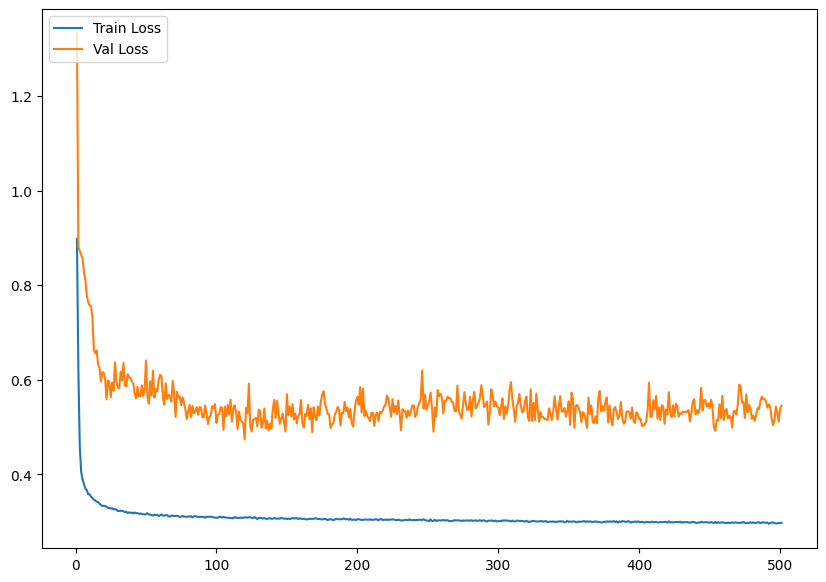

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.legend(loc="upper left")
plt.show()

# Eval

In [49]:
model.load_state_dict(torch.load(model_dir.absolute() / 'best_A3TGCN_model.pth'))


C:\Users\akhan147\AppData\Local\Temp\ipykernel_40340\1839563088.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_dir.absolute() / '

<All keys matched successfully>

## Test set

In [50]:
model.eval()
step = 0
# Store for analysis
total_loss = []
total_mape = []
total_mae = []

for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())
    total_mape.append(mean_absolute_percentage_error(labels, y_hat))
    total_mae.append(mean_absolute_error(labels, y_hat))
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))
print("Test MAE: {:.4f}".format(sum(total_mae)/len(total_mae)))
print("Test MAPE: {:.4f}%".format(sum(total_mape)/len(total_mape)))



Test MSE: 0.7865
Test MAE: 0.6319
Test MAPE: 148.6116%


In [51]:
labels.shape, y_hat.shape

(torch.Size([32, 10, 15]), torch.Size([32, 10, 15]))

In [52]:
sensor = 2
timestep = 0
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (32,)


<Axes: >

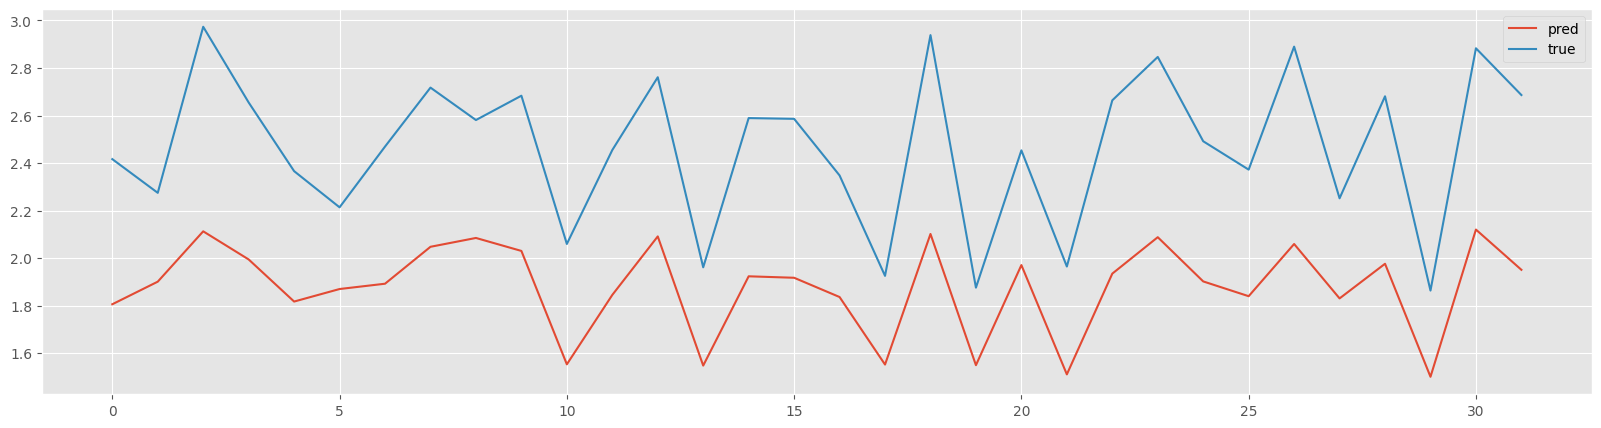

In [53]:
plt.style.use('ggplot')

plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")

## Train set

In [54]:
model.eval()
step = 0
# Store for analysis
total_loss = []
total_mape = []
total_mae = []

for encoder_inputs, labels in train_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())
    total_mape.append(mean_absolute_percentage_error(labels, y_hat))
    total_mae.append(mean_absolute_error(labels, y_hat))
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))
print("Test MAE: {:.4f}".format(sum(total_mae)/len(total_mae)))
print("Test MAPE: {:.4f}%".format(sum(total_mape)/len(total_mape)))



Test MSE: 0.3093
Test MAE: 0.3643
Test MAPE: 174.3115%


In [55]:
labels.shape, y_hat.shape

(torch.Size([32, 10, 15]), torch.Size([32, 10, 15]))

In [56]:
sensor = 2
timestep = 0
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (32,)


<Axes: >

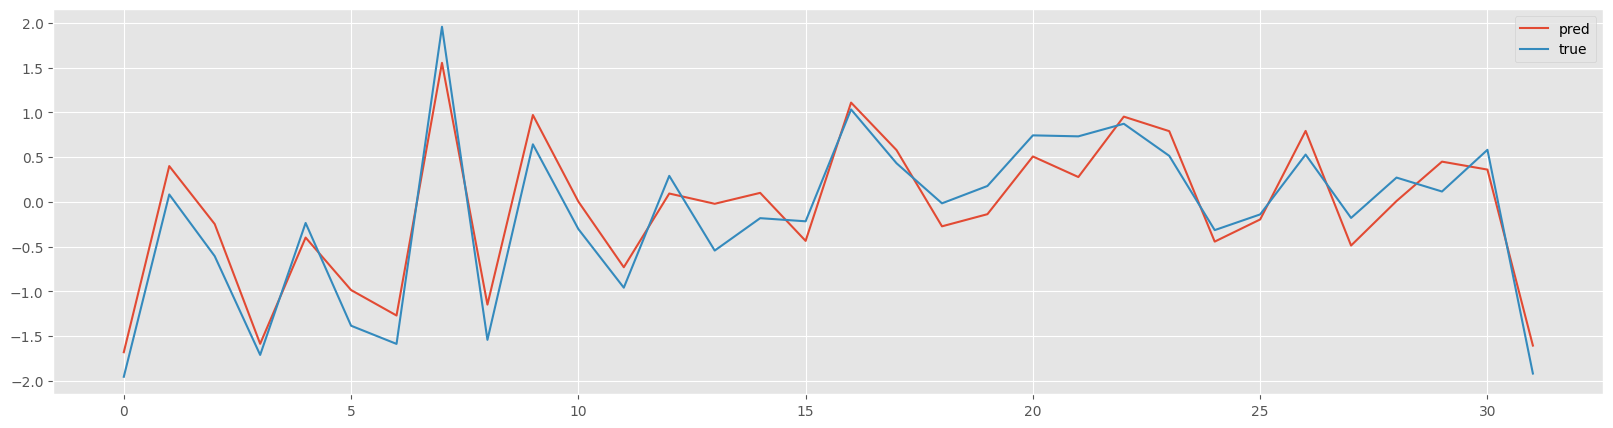

In [57]:
plt.style.use('ggplot')

plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")